In [1]:
import pandas as pd
from pathlib import Path

In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')

In [4]:
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

window = 50  # hoặc theo thời gian thực 
drop_threshold = 0.02

future_min = df['Price'][::-1].rolling(window).min()[::-1]
df['label'] = ((future_min - df['Price']) / df['Price'] <= -drop_threshold).astype(int)


In [5]:
df['label'].value_counts()

label
0    1472
1     321
Name: count, dtype: int64

In [6]:
df['Return_1'] = df['Price'].pct_change()
df['Return_5'] = df['Price'].pct_change(5)
df['Vol_rolling'] = df['Return_1'].rolling(20).std()


In [7]:
features = ['VPIN', 'Volume', 'BidAskSpread', 'AmihudLambda', 'RollImpact', 'RealizedVolatility', 
            'Return_1', 'Vol_rolling', 'MA_20', 'MA_50']
df = df.dropna(subset=features + ['label'])

split = int(len(df) * 0.7)
train, test = df.iloc[:split], df.iloc[split:]


In [8]:
df

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volume,VPIN,CDF,Roll,...,AR_ChangeSign,SkewnessSign,KurtosisSign,MA_20,MA_50,MASign,label,Return_1,Return_5,Vol_rolling
51,2025-09-07 07:10:56+00:00,83.794960,217.205040,110585.558575,110580.944302,110587.338703,301.0,0.170591,0.365826,166.951823,...,NaN,NaN,NaN,110524.149735,110779.274473,-1,0,-0.000187,0.003622,0.001261
52,2025-09-07 07:51:46+00:00,207.700500,93.299500,110753.874862,110767.574213,110723.377785,301.0,0.174827,0.435206,153.544379,...,NaN,NaN,NaN,110509.203634,110755.095610,-1,0,0.001522,0.004616,0.001217
53,2025-09-07 08:25:54+00:00,186.275490,114.724510,110933.480976,110939.504098,110923.701376,301.0,0.176210,0.452982,125.262949,...,NaN,NaN,NaN,110509.671601,110744.693723,-1,0,0.001622,0.004163,0.001252
54,2025-09-07 09:05:46+00:00,148.822780,152.177220,111185.051773,111202.501201,111167.986982,301.0,0.174921,0.435780,119.744351,...,NaN,NaN,NaN,110529.113214,110742.191060,-1,0,0.002268,0.005394,0.001318
55,2025-09-07 10:22:25+00:00,115.101770,185.898230,111116.266618,111113.729468,111117.837534,301.0,0.169580,0.351491,103.088969,...,NaN,NaN,NaN,110544.023024,110742.426084,-1,0,-0.000619,0.004611,0.001329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,2025-10-11 00:21:44+00:00,135.232603,165.767397,111865.293316,111864.041467,111866.314571,301.0,0.112994,0.031537,408.037414,...,1.0,1.0,-1.0,113206.953829,113138.078703,1,0,-0.000158,-0.005226,0.002657
1789,2025-10-11 00:27:30+00:00,134.450030,166.549970,112112.599528,112112.423045,112112.741997,301.0,0.114977,0.039564,387.956461,...,1.0,1.0,-1.0,113166.080550,113139.487903,1,0,0.002211,-0.005866,0.002721
1790,2025-10-11 00:35:48+00:00,145.012399,155.987601,112218.250719,112224.669607,112212.283461,301.0,0.112012,0.029817,404.887850,...,1.0,1.0,-1.0,113123.334714,113139.888248,-1,0,0.000942,-0.003616,0.002712
1791,2025-10-11 00:42:08+00:00,167.111134,133.888866,112379.427505,112380.059166,112378.639106,301.0,0.114094,0.036124,399.979021,...,1.0,1.0,-1.0,113084.793112,113135.113150,-1,0,0.001436,0.000614,0.002733


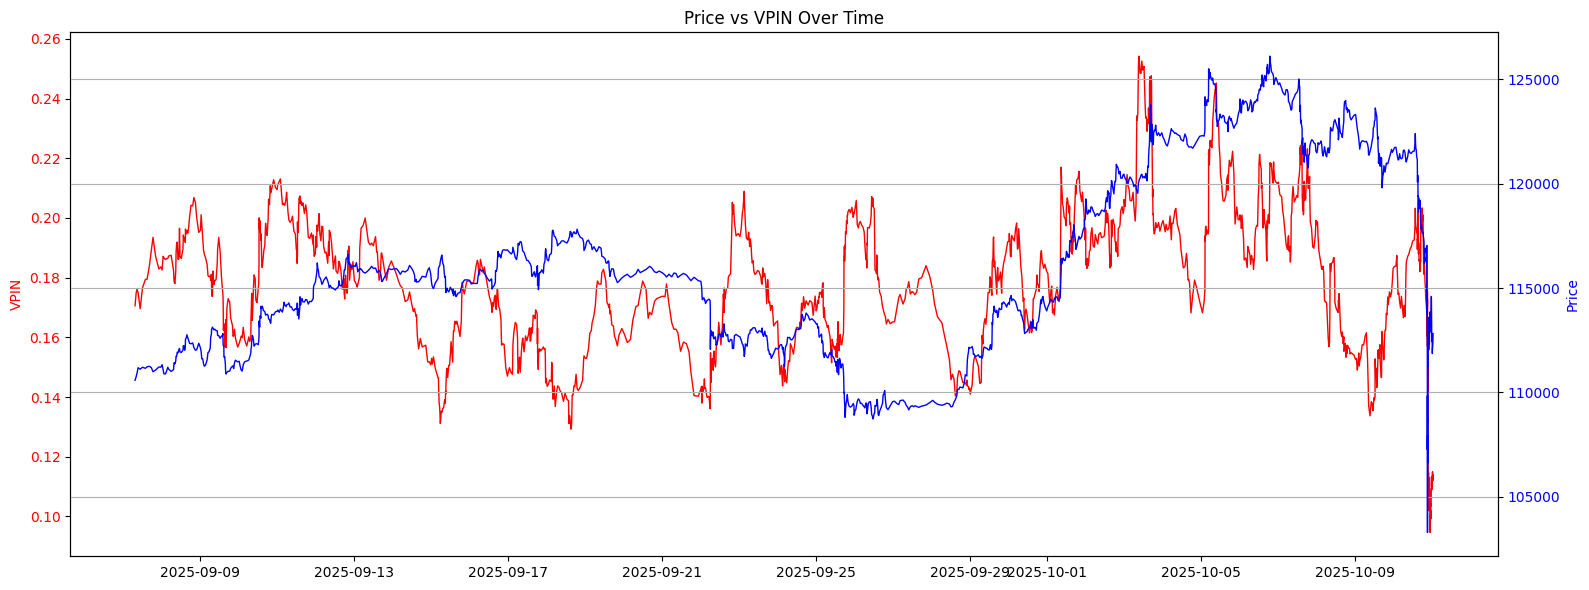

In [9]:
import matplotlib.pyplot as plt

df = df.sort_values("Time").reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(16,6))

# ===== VPIN (trục trái) =====
ax1.plot(df["Time"], df["VPIN"], color="red", linewidth=1.0, label="VPIN")
ax1.set_ylabel("VPIN", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# ===== Price (trục phải) =====
ax2 = ax1.twinx()
ax2.plot(df["Time"], df["Price"], color="blue", linewidth=1.0, label="Price")
ax2.set_ylabel("Price", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Price vs VPIN Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def build_true_events(times, labels):
    times = pd.to_datetime(times)
    true_events = []
    in_evt = False
    start = None

    for t, y in zip(times, labels):
        if y == 1 and not in_evt:
            in_evt = True
            start = t
        elif y == 0 and in_evt:
            true_events.append(start)
            in_evt = False
            start = None

    if in_evt and start is not None:
        true_events.append(start)

    return true_events

# Tạo true_events
true_events = build_true_events(df["Time"], df["label"])
print("Flash crash events:", true_events)

Flash crash events: [Timestamp('2025-09-18 14:36:00+0000', tz='UTC'), Timestamp('2025-09-18 16:19:35+0000', tz='UTC'), Timestamp('2025-09-18 18:54:40+0000', tz='UTC'), Timestamp('2025-09-19 20:01:45+0000', tz='UTC'), Timestamp('2025-09-22 03:58:04+0000', tz='UTC'), Timestamp('2025-09-24 14:43:51+0000', tz='UTC'), Timestamp('2025-09-25 13:15:09+0000', tz='UTC'), Timestamp('2025-09-25 14:17:34+0000', tz='UTC'), Timestamp('2025-10-05 04:47:23+0000', tz='UTC'), Timestamp('2025-10-05 07:11:06+0000', tz='UTC'), Timestamp('2025-10-06 17:30:18+0000', tz='UTC'), Timestamp('2025-10-06 18:52:11+0000', tz='UTC'), Timestamp('2025-10-08 17:35:07+0000', tz='UTC'), Timestamp('2025-10-08 23:25:52+0000', tz='UTC'), Timestamp('2025-10-09 11:19:38+0000', tz='UTC'), Timestamp('2025-10-09 21:36:09+0000', tz='UTC')]


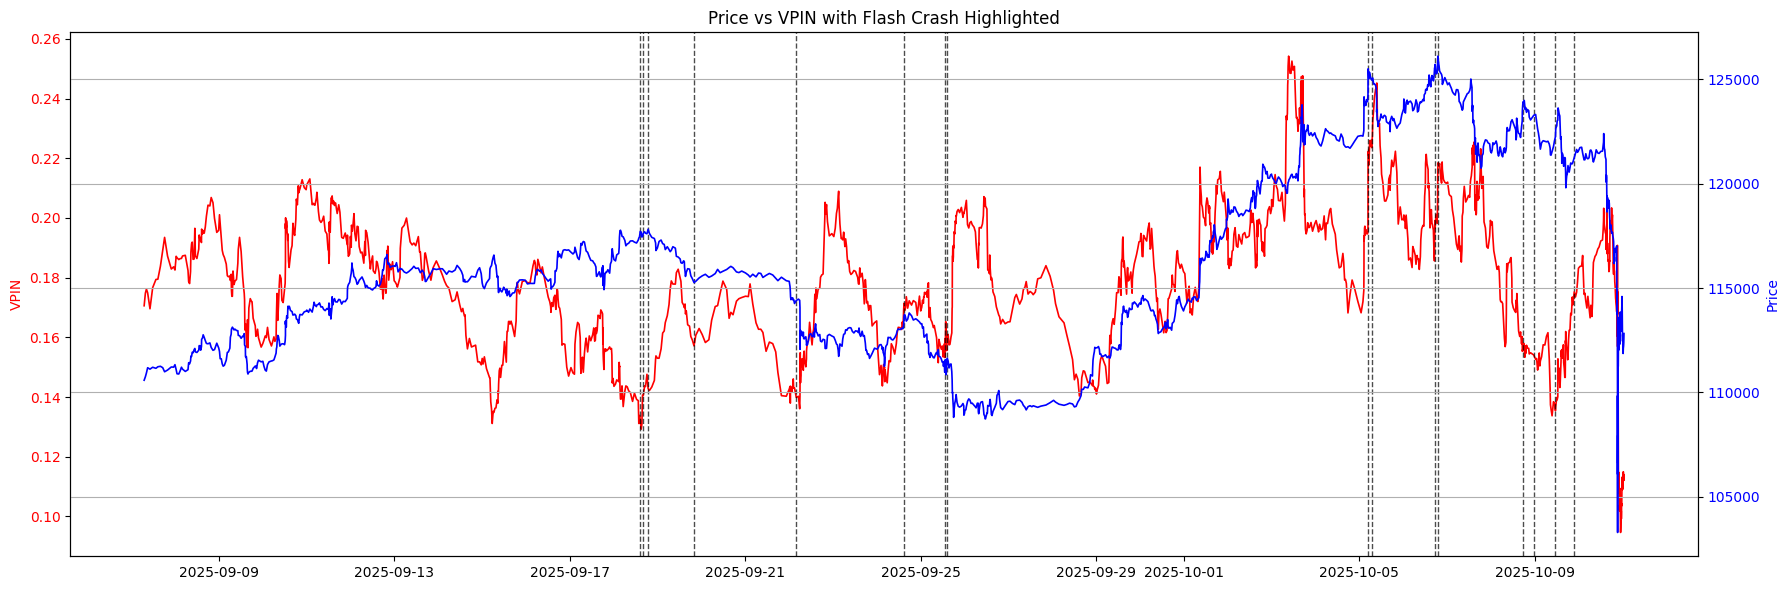

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# ---- Chuẩn hoá dataframe ----
df = df.sort_values("Time").reset_index(drop=True)

# ---- true_events: danh sách timestamp flash crash ----
# Nếu bạn đã có true_events thì bỏ qua đoạn tạo này
# true_events = build_true_events(df["Time"], df["label"])

fig, ax1 = plt.subplots(figsize=(18,6))

# ===========================
# VPIN (trục trái)
# ===========================
ax1.plot(df["Time"], df["VPIN"], color="red", linewidth=1.2, label="VPIN")
ax1.set_ylabel("VPIN", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# ===========================
# Price (trục phải)
# ===========================
ax2 = ax1.twinx()
ax2.plot(df["Time"], df["Price"], color="blue", linewidth=1.2, label="Price")
ax2.set_ylabel("Price", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# ===========================
# Highlight Flash Crash Events
# ===========================
for ev in true_events:
    ax1.axvline(ev, color="black", linestyle="--", linewidth=1.0, alpha=0.7)

# ===========================
# Title + Grid
# ===========================
plt.title("Price vs VPIN with Flash Crash Highlighted")
plt.grid(True)
plt.tight_layout()
plt.show()


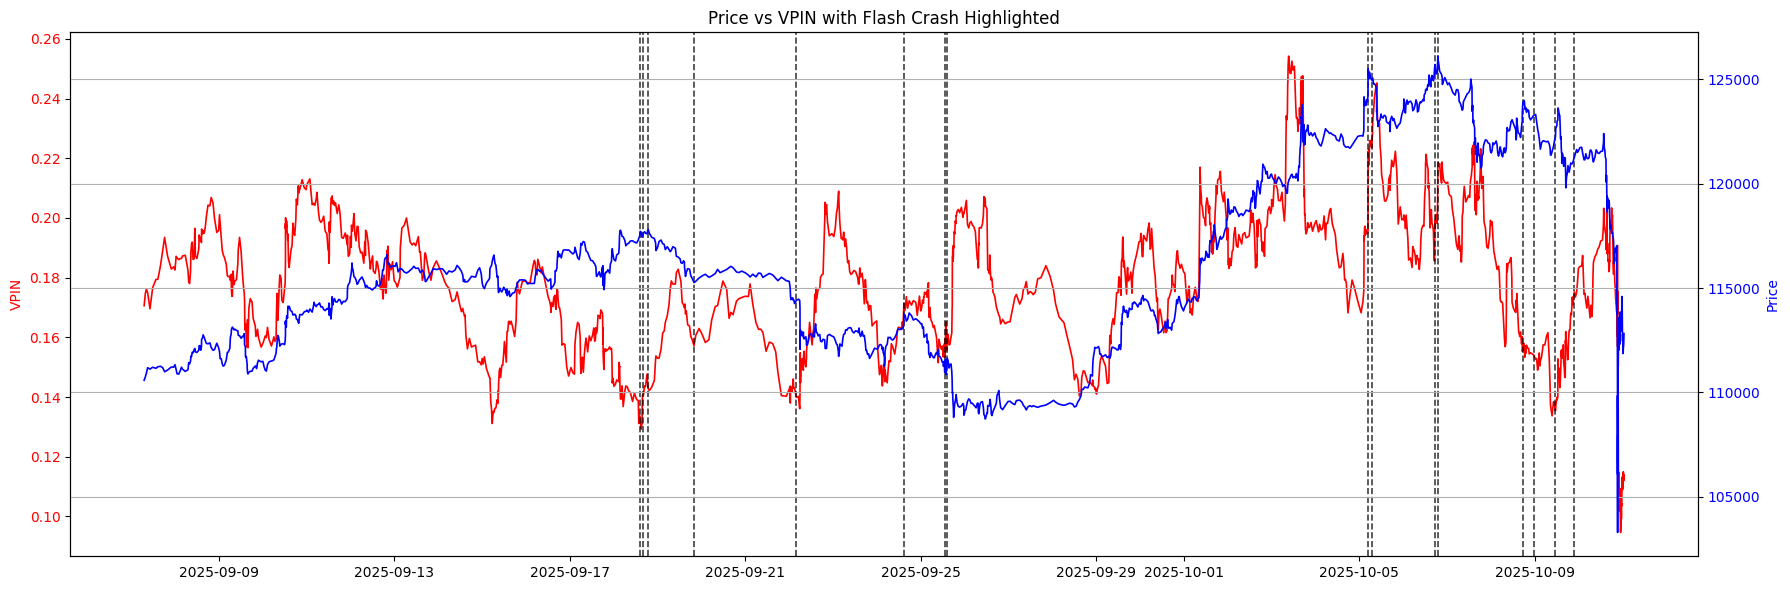

In [12]:
import matplotlib.pyplot as plt

df = df.sort_values("Time").reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(18,6))

# ===== VPIN (trục trái) =====
ax1.plot(df["Time"], df["VPIN"], color="red", linewidth=1.2, label="VPIN")
ax1.set_ylabel("VPIN", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# ===== Price (trục phải) =====
ax2 = ax1.twinx()
ax2.plot(df["Time"], df["Price"], color="blue", linewidth=1.2, label="Price")
ax2.set_ylabel("Price", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# ===== Highlight flash crash =====
for ev in true_events:
    ax1.axvline(ev, color="black", linestyle="--", linewidth=1.2, alpha=0.75)

plt.title("Price vs VPIN with Flash Crash Highlighted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

X_train, y_train = train[features], train['label']
X_test, y_test = test[features], test['label']

model = RandomForestClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.64      0.85      0.73       323
           1       0.50      0.24      0.33       200

    accuracy                           0.62       523
   macro avg       0.57      0.55      0.53       523
weighted avg       0.59      0.62      0.58       523

ROC-AUC: 0.5062383900928793


In [14]:
# ===========================
# LSTM/GRU FLASH-CRASH PREDICTOR (15 MIN AHEAD)
# ===========================
# Yêu cầu: PyTorch, scikit-learn, numpy, pandas, matplotlib (chỉ nếu muốn vẽ thêm).
# Tuỳ chọn: chỉnh các tham số ở "CONFIG".
# -------------------------------------------

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ============== CONFIG ==============
TIME_WINDOW = '30min'     # dự báo crash xảy ra trong 15 phút tới
DROP_PCT    = 0.01        # định nghĩa crash: giảm >= 2% trong cửa sổ tương lai
SEQ_LEN     = 40          # độ dài chuỗi đầu vào
BATCH_SIZE  = 256
LR          = 1e-3
EPOCHS      = 15
MODEL_TYPE  = 'GRU'      # 'LSTM' hoặc 'GRU'
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2
TRAIN_RATIO = 0.7         # chia train/test theo thời gian
SEED        = 42
# ====================================

torch.manual_seed(SEED)
np.random.seed(SEED)

# 1) Copy data để không đụng vào data gốc
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

# 2) Chọn các feature sẵn có (tự động lọc theo cột thực tế)
candidate_features = [
    'Buy','Sell','Price','BidPrice','AskPrice','Volume',
    'VPIN','CDF','Roll','RollImpact','KyleLambda','Returns',
    'AmihudLambda','BidAskSpread','SpreadChangeSign',
    'RealizedVolatility','RealizedVolatilitySign','ReturnsSign',
    'Skewness','Kurtosis','JB_rolling','JB_ChangeSign','AR',
    'AR_ChangeSign','SkewnessSign','KurtosisSign','MA_20','MA_50','MASign'
]
features = [c for c in candidate_features if c in df.columns]

# Bổ sung vài đặc trưng động học ngắn hạn (nếu có Price, Volume, BidAskSpread, VPIN)
if 'Price' in df.columns:
    df['Return_1'] = df['Price'].pct_change()
    df['Return_5'] = df['Price'].pct_change(5)
    features += ['Return_1','Return_5']
if 'Volume' in df.columns:
    df['Vol_jump'] = df['Volume'].pct_change().clip(-1,1)
    features += ['Vol_jump']
if 'BidAskSpread' in df.columns:
    df['Spread_change'] = df['BidAskSpread'].diff()
    features += ['Spread_change']
if 'VPIN' in df.columns:
    df['VPIN_change'] = df['VPIN'].diff()
    features += ['VPIN_change']

# 3) Tạo nhãn (label) dựa trên sụt giảm tối thiểu trong TIME_WINDOW tới
times = df['Time'].values

def future_min_in_time_window(prices: np.ndarray, times: np.ndarray, window: pd.Timedelta):
    """
    Với mỗi i, tìm min(Price) trong khoảng thời gian [Time[i], Time[i]+window].
    Trả về mảng future_min cùng kích thước.
    """
    n = len(prices)
    fut_min = np.full(n, np.nan, dtype=float)
    for i in range(n):
        t_end = pd.Timestamp(times[i]) + window
        j_end = np.searchsorted(times, np.datetime64(t_end), side='right')
        if j_end <= i + 1:
            fut_min[i] = prices[i]  # không có tương lai: coi như không đổi
        else:
            fut_min[i] = np.nanmin(prices[i:j_end])
    return fut_min

price = df['Price'].astype(float).values
fut_min = future_min_in_time_window(price, times, pd.Timedelta(TIME_WINDOW))
drop = (fut_min - price) / price
df['label'] = (drop <= -DROP_PCT).astype(int)

# 4) Làm sạch NaN do diff/pct_change và đảm bảo đủ cột
use_cols = features + ['label','Time']
df = df[use_cols].dropna().reset_index(drop=True)

# 5) Chia train/test theo thời gian
split_idx = int(len(df) * TRAIN_RATIO)
train_df = df.iloc[:split_idx].reset_index(drop=True)
test_df  = df.iloc[split_idx:].reset_index(drop=True)

# 6) Chuẩn hoá (fit scaler trên TRAIN, transform cả TRAIN/TEST)
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(train_df[features].values)
X_test_2d  = scaler.transform(test_df[features].values)

# 7) Chuyển sang các chuỗi SEQ_LEN (windowed sequences)
def build_sequences(X_2d: np.ndarray, y_1d: np.ndarray, seq_len: int):
    """
    Trả về:
      X_seq: (num_seq, seq_len, num_features)
      y_seq: (num_seq,)  (nhãn tại thời điểm cuối chuỗi)
    """
    n = len(X_2d)
    xs, ys = [], []
    for i in range(n - seq_len):
        xs.append(X_2d[i:i+seq_len, :])
        ys.append(y_1d[i + seq_len])  # nhãn "tương lai gần" tại vị trí sau cùng chuỗi
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)

y_train_1d = train_df['label'].values.astype(np.float32)
y_test_1d  = test_df['label'].values.astype(np.float32)

X_train_seq, y_train_seq = build_sequences(X_train_2d, y_train_1d, SEQ_LEN)
X_test_seq,  y_test_seq  = build_sequences(X_test_2d,  y_test_1d,  SEQ_LEN)

# 8) Dataset & DataLoader
class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y)  # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_ds = SeqDS(X_train_seq, y_train_seq)
test_ds  = SeqDS(X_test_seq,  y_test_seq)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)  # time-series: không shuffle
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# 9) Model: LSTM hoặc GRU + head nhị phân
class RNNBinary(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, rnn_type='LSTM'):
        super().__init__()
        if rnn_type.upper() == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers,
                              batch_first=True, dropout=(dropout if num_layers > 1 else 0.0))
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, dropout=(dropout if num_layers > 1 else 0.0))
        self.rnn_type = rnn_type.upper()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # logit
        )
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.rnn(x)          # (B, T, H)
        h_last = out[:, -1, :]        # lấy hidden cuối chuỗi
        logit = self.head(h_last).squeeze(1)  # (B,)
        return logit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNBinary(
    input_size=len(features),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    rnn_type=MODEL_TYPE
).to(device)

# 10) Loss với pos_weight để cân bằng lớp hiếm
pos = y_train_seq.sum()
neg = len(y_train_seq) - pos
pos_weight = torch.tensor([(neg / max(pos, 1.0))], dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def evaluate(loader):
    model.eval()
    total_loss, n = 0.0, 0
    y_true_all, y_prob_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * len(xb)
            n += len(xb)
            y_true_all.append(yb.detach().cpu().numpy())
            y_prob_all.append(torch.sigmoid(logits).detach().cpu().numpy())
    y_true = np.concatenate(y_true_all)
    y_prob = np.concatenate(y_prob_all)
    return total_loss / max(n,1), y_true, y_prob

# 11) Train loop đơn giản + early stop nhẹ theo val=test (có thể tách val riêng nếu muốn)
best_loss = float('inf')
patience, wait = 5, 0
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    val_loss, y_true_test, y_prob_test = evaluate(test_loader)
    print(f'Epoch {epoch:02d} | val_loss={val_loss:.4f}')
    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        wait = 0
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping.')
            break

# Load best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# 12) Đánh giá cơ bản: ngưỡng 0.5 (có thể tinh chỉnh theo PR-AUC/Recall@K)
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

_, y_true_test, y_prob_test = evaluate(test_loader)
y_pred_test = (y_prob_test >= 0.5).astype(int)
try:
    roc = roc_auc_score(y_true_test, y_prob_test)
except:
    roc = float('nan')
ap = average_precision_score(y_true_test, y_prob_test)

print(classification_report(y_true_test, y_pred_test, digits=3))
print('ROC-AUC:', roc)
print('PR-AUC (Average Precision):', ap)

# 13) Suy luận xác suất theo thời gian để bạn có thể gán về timestamp tương ứng
# Khớp chuỗi test với mốc thời gian (thời điểm target nằm ở index SEQ_LEN + i trong test_df)
test_times = test_df['Time'].values
aligned_times = test_times[SEQ_LEN:]  # mỗi y_pred_test/y_prob_test tương ứng thời điểm này
pred_df = pd.DataFrame({
    'Time': pd.to_datetime(aligned_times),
    'y_true': y_true_test.astype(int),
    'y_prob': y_prob_test,
    'y_pred': y_pred_test.astype(int)
})
# Lọc cảnh báo mạnh
alerts = pred_df[pred_df['y_prob'] >= 0.8].copy()
print(f"Số cảnh báo mạnh (prob ≥ 0.8): {len(alerts)}")


Epoch 01 | val_loss=18.2740
Epoch 02 | val_loss=20.2881
Epoch 03 | val_loss=22.8283
Epoch 04 | val_loss=26.2456
Epoch 05 | val_loss=30.7665
Epoch 06 | val_loss=36.1389
Early stopping.
              precision    recall  f1-score   support

         0.0      0.707     0.372     0.488       395
         1.0      0.046     0.164     0.072        73

    accuracy                          0.340       468
   macro avg      0.376     0.268     0.280       468
weighted avg      0.604     0.340     0.423       468

ROC-AUC: 0.2297901855384082
PR-AUC (Average Precision): 0.09948500406654726
Số cảnh báo mạnh (prob ≥ 0.8): 66


In [15]:
# ===========================
# GRU FLASH-CRASH PREDICTOR (30 MIN AHEAD, focal loss + z-features)
# ===========================

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

# ============== CONFIG ==============
TIME_WINDOW = "30min"
DROP_PCT = 0.01
SEQ_LEN = 40
BATCH_SIZE = 256
LR = 3e-4
EPOCHS = 20
MODEL_TYPE = "GRU"
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.3
TRAIN_RATIO = 0.7
WEIGHT_DECAY = 1e-4
CLIP_NORM = 1.0
SEED = 42
# ====================================

torch.manual_seed(SEED)
np.random.seed(SEED)

# 1) Copy data để không đụng vào data gốc
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").reset_index(drop=True)

# 2) Chọn các feature hiện có
candidate_features = [
    "Buy","Sell","Price","BidPrice","AskPrice","Volume","VPIN","CDF","Roll","RollImpact","KyleLambda",
    "Returns","AmihudLambda","BidAskSpread","SpreadChangeSign","RealizedVolatility","RealizedVolatilitySign",
    "ReturnsSign","Skewness","Kurtosis","JB_rolling","JB_ChangeSign","AR","AR_ChangeSign","SkewnessSign",
    "KurtosisSign","MA_20","MA_50","MASign"
]
features = [c for c in candidate_features if c in df.columns]

# Bổ sung các đặc trưng ngắn hạn và z-score
if "Price" in df:
    df["Return_1"] = df["Price"].pct_change()
    df["Return_5"] = df["Price"].pct_change(5)
    features += ["Return_1", "Return_5"]
if "Volume" in df:
    df["Vol_jump"] = df["Volume"].pct_change().clip(-1, 1)
    features += ["Vol_jump"]
if "BidAskSpread" in df:
    df["Spread_change"] = df["BidAskSpread"].diff()
    features += ["Spread_change"]
if "VPIN" in df:
    df["VPIN_change"] = df["VPIN"].diff()
    features += ["VPIN_change"]

for col in ["VPIN", "BidAskSpread", "RealizedVolatility"]:
    if col in df:
        roll = df[col].rolling(200, min_periods=50)
        df[f"{col}_z"] = (df[col] - roll.mean()) / roll.std()
        features.append(f"{col}_z")

# 3) Tạo nhãn crash
def future_min(prices, times, window):
    n = len(prices)
    fut = np.full(n, np.nan)
    for i in range(n):
        t_end = pd.Timestamp(times[i]) + window
        j_end = np.searchsorted(times, np.datetime64(t_end), side="right")
        fut[i] = prices[i] if j_end <= i + 1 else np.nanmin(prices[i:j_end])
    return fut

times = df["Time"].values
price = df["Price"].astype(float).values
fut_min = future_min(price, times, pd.Timedelta(TIME_WINDOW))
drop = (fut_min - price) / price
df["label"] = (drop <= -DROP_PCT).astype(int)

use_cols = features + ["label", "Time"]
df = df[use_cols].dropna().reset_index(drop=True)

# 4) Train/Test split
split = int(len(df) * TRAIN_RATIO)
train_df, test_df = df.iloc[:split], df.iloc[split:]

# 5) Scaler
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(train_df[features])
X_test_2d = scaler.transform(test_df[features])

# 6) Build sequences
def build_seq(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

y_train = train_df["label"].values.astype(np.float32)
y_test = test_df["label"].values.astype(np.float32)
X_train, y_train = build_seq(X_train_2d, y_train, SEQ_LEN)
X_test, y_test = build_seq(X_test_2d, y_test, SEQ_LEN)

class SeqDS(Dataset):
    def __init__(self, X, y): self.X, self.y = torch.from_numpy(X), torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(SeqDS(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SeqDS(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False)

# 7) Model
class RNNBinary(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, rnn_type):
        super().__init__()
        if rnn_type.upper() == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers,
                              batch_first=True, dropout=(dropout if num_layers>1 else 0))
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, dropout=(dropout if num_layers>1 else 0))
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size, 1))
    def forward(self, x):
        out,_ = self.rnn(x)
        h = out[:, -1, :]
        return self.head(h).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNBinary(len(features), HIDDEN_SIZE, NUM_LAYERS, DROPOUT, MODEL_TYPE).to(device)

# 8) Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0): super().__init__(); self.a, self.g = alpha, gamma
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = p*targets + (1-p)*(1-targets)
        w = self.a*targets + (1-self.a)*(1-targets)
        return (w*(1-pt).pow(self.g)*ce).mean()

criterion = FocalLoss(alpha=0.85, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

def evaluate(loader):
    model.eval()
    y_true, y_prob, loss_sum, n = [], [], 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logit = model(xb)
            loss = criterion(logit, yb)
            loss_sum += loss.item()*len(xb); n += len(xb)
            y_true.append(yb.cpu().numpy())
            y_prob.append(torch.sigmoid(logit).cpu().numpy())
    return loss_sum/max(n,1), np.concatenate(y_true), np.concatenate(y_prob)

# 9) Train
best_loss = np.inf; patience, wait = 5, 0
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logit = model(xb)
        loss = criterion(logit, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
    val_loss, y_true_t, y_prob_t = evaluate(test_loader)
    scheduler.step(val_loss)
    print(f"Epoch {ep:02d} | val_loss={val_loss:.4f}")
    if val_loss < best_loss - 1e-4:
        best_loss, wait = val_loss, 0
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}
    else:
        wait += 1
        if wait>=patience: print("Early stopping."); break

model.load_state_dict({k:v.to(device) for k,v in best_state.items()})

# 10) Đánh giá & threshold tối ưu theo F2
_, y_true, y_prob = evaluate(test_loader)
prec, rec, thr = precision_recall_curve(y_true, y_prob)
f2 = (5*prec*rec)/(4*prec+rec+1e-12)
best_thr = thr[max(np.nanargmax(f2)-1,0)] if len(thr)>0 else 0.5
y_pred = (y_prob >= best_thr).astype(int)

roc = roc_auc_score(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
print(classification_report(y_true, y_pred, digits=3))
print(f"ROC-AUC: {roc:.3f}")
print(f"PR-AUC (AP): {ap:.3f}")
print(f"Best F2 threshold: {best_thr:.3f}")

# 11) Xuất kết quả
aligned_times = test_df["Time"].values[SEQ_LEN:]
pred_df = pd.DataFrame({"Time": pd.to_datetime(aligned_times),
                        "y_true": y_true.astype(int),
                        "y_prob": y_prob,
                        "y_pred": y_pred.astype(int)})
alerts = pred_df[pred_df["y_prob"] >= 0.8]
print(f"Số cảnh báo mạnh (prob ≥ 0.8): {len(alerts)}")


Epoch 01 | val_loss=0.0634
Epoch 02 | val_loss=0.0627
Epoch 03 | val_loss=0.0628
Epoch 04 | val_loss=0.0639
Epoch 05 | val_loss=0.0663
Epoch 06 | val_loss=0.0681
Epoch 07 | val_loss=0.0704
Early stopping.
              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       395
         1.0      0.156     1.000     0.270        73

    accuracy                          0.156       468
   macro avg      0.078     0.500     0.135       468
weighted avg      0.024     0.156     0.042       468

ROC-AUC: 0.332
PR-AUC (AP): 0.128
Best F2 threshold: 0.289
Số cảnh báo mạnh (prob ≥ 0.8): 0


/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [16]:
# ================== POST-PROCESSING: chọn ngưỡng theo precision tối thiểu + đánh giá theo sự kiện ==================

from sklearn.metrics import precision_recall_curve, confusion_matrix

# 1) Chọn ngưỡng đạt PRECISION TỐI THIỂU mong muốn, ưu tiên recall cao nhất
TARGET_PRECISION = 0.30  # bạn có thể chỉnh lên 0.40 - 0.50 nếu muốn "ít báo động giả" hơn
prec, rec, thr = precision_recall_curve(y_true, y_prob)

def select_threshold_by_precision(prec, rec, thr, pmin=0.30):
    # tìm mọi ngưỡng có precision >= pmin, lấy ngưỡng cho recall lớn nhất
    cands = [(P, R, T) for P,R,T in zip(prec[:-1], rec[:-1], thr) if P >= pmin]
    if not cands:
        # nếu không có ngưỡng nào đạt precision tối thiểu, fallback: dùng best F2 đã tính
        return float(best_thr)
    # chọn theo recall tối đa, nếu hoà thì lấy ngưỡng lớn hơn (thận trọng)
    cands.sort(key=lambda x: (x[1], x[2]))  # sort by recall, then threshold
    return float(cands[-1][2])

thr_prec = select_threshold_by_precision(prec, rec, thr, pmin=TARGET_PRECISION)
y_pred_prec = (y_prob >= thr_prec).astype(int)

print(f"[Threshold by Precision≥{TARGET_PRECISION:.2f}] thres={thr_prec:.3f}")
print(classification_report(y_true, y_pred_prec, digits=3))
cm = confusion_matrix(y_true, y_pred_prec, labels=[1,0])
print("Confusion matrix [rows=true 1/0, cols=pred 1/0]:\n", cm)

# 2) Đánh giá THEO SỰ KIỆN: gộp dự đoán liên tiếp bằng cooldown; khớp với crash thật trong cửa sổ đối sánh
#    - giả định 'y_true' là nhãn tại mỗi timestamp 'aligned_times' (SEQUENCE cuối)
#    - "sự kiện thật" ~ cụm các điểm y_true==1 gần nhau -> quy về thời điểm bắt đầu cụm đó.
pred_df = pred_df.sort_values("Time").reset_index(drop=True)
COOLDOWN = pd.Timedelta("10min")   # không tạo 2 cảnh báo quá gần nhau
MATCH_WIN = pd.Timedelta("20min")  # dự đoán được coi là đúng nếu cách sự kiện thật ≤ 20 phút
USE_THRESHOLD = thr_prec           # có thể đổi sang best_thr nếu muốn recall cao hơn

# Tạo sự kiện dự đoán (dựa trên y_prob >= USE_THRESHOLD)
pred_events = []
last = None
for t, p in zip(pred_df["Time"].values, y_prob):
    if p >= USE_THRESHOLD and (last is None or (pd.Timestamp(t) - last) >= COOLDOWN):
        pred_events.append(pd.Timestamp(t)); last = pd.Timestamp(t)

# Tạo sự kiện thật từ chuỗi nhãn y_true (gom chuỗi 1 liên tiếp)
true_events = []
in_event = False
event_start = None
for t, y in zip(pred_df["Time"].values, y_true):
    if y == 1 and not in_event:
        in_event = True
        event_start = pd.Timestamp(t)
    elif y == 0 and in_event:
        true_events.append(event_start)
        in_event = False
if in_event and event_start is not None:
    true_events.append(event_start)

# Khớp sự kiện
tp, fp = 0, 0
matched_true = set()
for pe in pred_events:
    # tìm event thật gần nhất trong cửa sổ cho phép
    candidates = [te for te in true_events if abs(pe - te) <= MATCH_WIN and te not in matched_true]
    if candidates:
        te = min(candidates, key=lambda x: abs(pe - x))
        matched_true.add(te)
        tp += 1
    else:
        fp += 1
fn = len(true_events) - tp
event_precision = tp / max(tp + fp, 1)
event_recall = tp / max(tp + fn, 1)
print(f"[Event-level] events_true={len(true_events)}, events_pred={len(pred_events)}, TP={tp}, FP={fp}, FN={fn}")
print(f"[Event-level] Precision={event_precision:.3f}, Recall={event_recall:.3f}")

# 3) Tạo danh sách ALERTS theo ngưỡng đã chọn + cooldown (để dùng thực chiến)
alerts = pd.DataFrame({"Time": pred_events})
print(f"Số ALERTS sau cooldown (thr={USE_THRESHOLD:.3f}): {len(alerts)}")

# 4) (Tuỳ chọn) Tạo ngưỡng theo ngân sách cảnh báo/ngày, nếu muốn cố định ~N alert/ngày
ALERTS_PER_DAY = None  # ví dụ đặt = 5 để giới hạn ~5 alert/ngày; để None nếu không dùng
if ALERTS_PER_DAY:
    # duyệt các ngưỡng, chọn ngưỡng cho số alert/ngày gần mục tiêu nhất (trên tập test)
    def alerts_per_day(th):
        last = None; cnt = {}
        for t, p in zip(pred_df["Time"].values, y_prob):
            if p >= th and (last is None or (pd.Timestamp(t) - last) >= COOLDOWN):
                d = pd.Timestamp(t).date()
                cnt[d] = cnt.get(d, 0) + 1
                last = pd.Timestamp(t)
        return np.mean(list(cnt.values())) if cnt else 0.0

    grid = np.linspace(0.1, 0.9, 33)
    best_th = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))
    print(f"[Alert budget] Chọn threshold ≈ {best_th:.3f} cho ~{ALERTS_PER_DAY} alert/ngày (ước lượng).")


[Threshold by Precision≥0.30] thres=0.289
              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       395
         1.0      0.156     1.000     0.270        73

    accuracy                          0.156       468
   macro avg      0.078     0.500     0.135       468
weighted avg      0.024     0.156     0.042       468

Confusion matrix [rows=true 1/0, cols=pred 1/0]:
 [[ 73   0]
 [395   0]]
[Event-level] events_true=13, events_pred=281, TP=13, FP=268, FN=0
[Event-level] Precision=0.046, Recall=1.000
Số ALERTS sau cooldown (thr=0.289): 281


/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [17]:
# ============================================================
# ENSEMBLE + COOLDOWN DÀI + ALERT BUDGET 5/DAY
# ============================================================
from sklearn.metrics import precision_recall_curve, confusion_matrix

# 1️⃣  Chọn ngưỡng dựa trên ngân sách cảnh báo ~5 alert/ngày
COOLDOWN = pd.Timedelta("30min")
ALERTS_PER_DAY = 5

def alerts_per_day(threshold):
    last = None
    counts = {}
    for t, p in zip(pred_df["Time"].values, y_prob):
        if p >= threshold and (last is None or (pd.Timestamp(t) - last) >= COOLDOWN):
            day = pd.Timestamp(t).date()
            counts[day] = counts.get(day, 0) + 1
            last = pd.Timestamp(t)
    return np.mean(list(counts.values())) if counts else 0.0

grid = np.linspace(0.1, 0.9, 33)
best_thr = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))
print(f"[Alert budget] chọn threshold ≈ {best_thr:.3f} để đạt ~{ALERTS_PER_DAY} cảnh báo/ngày")

# 2️⃣  Ensemble rule: chỉ giữ cảnh báo nếu có VPIN_z hoặc Spread_z cao
VPIN_Z_THR = 1.5
SPREAD_Z_THR = 1.0

# Thêm các cột nếu có
if "VPIN_z" in test_df.columns:
    pred_df["VPIN_z"] = test_df["VPIN_z"].values[SEQ_LEN:]
else:
    pred_df["VPIN_z"] = 0
if "BidAskSpread_z" in test_df.columns:
    pred_df["BidAskSpread_z"] = test_df["BidAskSpread_z"].values[SEQ_LEN:]
else:
    pred_df["BidAskSpread_z"] = 0

pred_df["ensemble_flag"] = (
    (pred_df["y_prob"] >= best_thr)
    & ((pred_df["VPIN_z"] >= VPIN_Z_THR) | (pred_df["BidAskSpread_z"] >= SPREAD_Z_THR))
)

# 3️⃣  Gộp các cảnh báo theo cooldown dài
pred_events = []
last = None
for t, f in zip(pred_df["Time"].values, pred_df["ensemble_flag"].values):
    if f and (last is None or (pd.Timestamp(t) - last) >= COOLDOWN):
        pred_events.append(pd.Timestamp(t))
        last = pd.Timestamp(t)

# 4️⃣  Sự kiện thật (gom chuỗi y_true==1 liên tiếp)
true_events = []
in_event = False
event_start = None
for t, y in zip(pred_df["Time"].values, y_true):
    if y == 1 and not in_event:
        in_event = True
        event_start = pd.Timestamp(t)
    elif y == 0 and in_event:
        true_events.append(event_start)
        in_event = False
if in_event and event_start is not None:
    true_events.append(event_start)

# 5️⃣  Đánh giá event-level (20 phút khớp)
MATCH_WIN = pd.Timedelta("20min")
tp, fp = 0, 0
matched_true = set()
for pe in pred_events:
    candidates = [te for te in true_events if abs(pe - te) <= MATCH_WIN and te not in matched_true]
    if candidates:
        te = min(candidates, key=lambda x: abs(pe - x))
        matched_true.add(te)
        tp += 1
    else:
        fp += 1
fn = len(true_events) - tp
prec_ev = tp / max(tp + fp, 1)
rec_ev = tp / max(tp + fn, 1)

print(f"[Event-level ensemble] TP={tp}, FP={fp}, FN={fn}")
print(f"[Event-level ensemble] Precision={prec_ev:.3f}, Recall={rec_ev:.3f}")
print(f"Số ALERTS (cooldown 30min, thr={best_thr:.3f}): {len(pred_events)}")

# 6️⃣  Xuất DataFrame ALERTS (thời điểm cảnh báo)
alerts = pd.DataFrame({"Time": pred_events})
alerts.head()


[Alert budget] chọn threshold ≈ 0.400 để đạt ~5 cảnh báo/ngày
[Event-level ensemble] TP=1, FP=1, FN=12
[Event-level ensemble] Precision=0.500, Recall=0.077
Số ALERTS (cooldown 30min, thr=0.400): 2


,Time
0,2025-10-10 13:44:13
1,2025-10-10 14:58:08


In [18]:
# ============================================================
# AUTO-ENSEMBLE + COOLDOWN + ALERT BUDGET (FINAL VERSION)
# ============================================================
from sklearn.metrics import precision_recall_curve, confusion_matrix

# ==== CONFIG ====
ALERTS_PER_DAY = 10          # mục tiêu số cảnh báo trung bình mỗi ngày
COOLDOWN = pd.Timedelta("15min")  # thời gian gộp cảnh báo gần nhau
MATCH_WIN = pd.Timedelta("20min") # khớp crash thật trong ±20 phút
VPIN_GRID = [0.8, 1.0, 1.2]       # dải VPIN_z thử
SPREAD_GRID = [0.5, 0.8, 1.0]     # dải Spread_z thử
# =================

# 1️⃣ Tự động chọn threshold (prob) để đạt ngân sách cảnh báo
def alerts_per_day(threshold):
    last = None; counts = {}
    for t, p in zip(pred_df["Time"].values, y_prob):
        if p >= threshold and (last is None or (pd.Timestamp(t)-last) >= COOLDOWN):
            d = pd.Timestamp(t).date()
            counts[d] = counts.get(d, 0) + 1
            last = pd.Timestamp(t)
    return np.mean(list(counts.values())) if counts else 0.0

grid = np.linspace(0.1, 0.9, 33)
best_thr = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))
print(f"[Alert budget] chọn threshold ≈ {best_thr:.3f} (~{ALERTS_PER_DAY} cảnh báo/ngày)")

# 2️⃣ Chuẩn bị dữ liệu ensemble
if "VPIN_z" in test_df.columns:
    pred_df["VPIN_z"] = test_df["VPIN_z"].values[SEQ_LEN:]
else:
    pred_df["VPIN_z"] = 0
if "BidAskSpread_z" in test_df.columns:
    pred_df["BidAskSpread_z"] = test_df["BidAskSpread_z"].values[SEQ_LEN:]
else:
    pred_df["BidAskSpread_z"] = 0

# 3️⃣ Auto-tune ensemble thresholds
def evaluate_event_level(vpin_thr, spread_thr):
    # ensemble rule
    mask = (pred_df["y_prob"] >= best_thr) & (
        (pred_df["VPIN_z"] >= vpin_thr) | (pred_df["BidAskSpread_z"] >= spread_thr)
    )
    # tạo event dự đoán
    pred_events, last = [], None
    for t, f in zip(pred_df["Time"].values, mask):
        if f and (last is None or (pd.Timestamp(t)-last) >= COOLDOWN):
            pred_events.append(pd.Timestamp(t)); last = pd.Timestamp(t)
    # tạo event thật
    true_events = []; in_evt = False; start = None
    for t, y in zip(pred_df["Time"].values, y_true):
        if y == 1 and not in_evt:
            in_evt, start = True, pd.Timestamp(t)
        elif y == 0 and in_evt:
            true_events.append(start); in_evt = False
    if in_evt and start is not None:
        true_events.append(start)
    # khớp event
    tp=fp=0; matched=set()
    for pe in pred_events:
        cand=[te for te in true_events if abs(pe-te)<=MATCH_WIN and te not in matched]
        if cand:
            te=min(cand,key=lambda x:abs(pe-x))
            matched.add(te); tp+=1
        else:
            fp+=1
    fn=len(true_events)-tp
    prec=tp/max(tp+fp,1); rec=tp/max(tp+fn,1)
    return prec, rec, len(pred_events)

best_combo=(0,0,0,0)
for vthr in VPIN_GRID:
    for sthr in SPREAD_GRID:
        p,r,n=evaluate_event_level(vthr,sthr)
        f2=(5*p*r)/(4*p+r+1e-9)
        if f2>best_combo[3]:
            best_combo=(vthr,sthr,p,r,f2,n)
vthr,sthr,prec_ev,rec_ev,_,n_alerts=best_combo
print(f"[Auto-ensemble] VPIN_z≥{vthr:.2f}, Spread_z≥{sthr:.2f}")
print(f"[Event-level] Precision={prec_ev:.3f}, Recall={rec_ev:.3f}, Alerts={n_alerts}")

# 4️⃣  Sinh danh sách cảnh báo cuối cùng
# mask_final = (pred_df["y_prob"] >= best_thr) & (
#     (pred_df["VPIN_z"] >= vthr) | (pred_df["BidAskSpread_z"] >= sthr)
# )
mask_final = (pred_df["y_prob"] >= best_thr) & (pred_df["VPIN_z"] >= 0.9)

pred_events, last = [], None
for t, f in zip(pred_df["Time"].values, mask_final):
    if f and (last is None or (pd.Timestamp(t)-last) >= COOLDOWN):
        pred_events.append(pd.Timestamp(t)); last = pd.Timestamp(t)

alerts = pd.DataFrame({"Time": pred_events})
print(f"Số ALERTS (cooldown={COOLDOWN}, thr={best_thr:.3f}): {len(alerts)}")
alerts.head()


[Alert budget] chọn threshold ≈ 0.400 (~10 cảnh báo/ngày)
[Auto-ensemble] VPIN_z≥1.20, Spread_z≥1.00
[Event-level] Precision=0.500, Recall=0.077, Alerts=2
Số ALERTS (cooldown=0 days 00:15:00, thr=0.400): 2


,Time
0,2025-10-10 13:37:59
1,2025-10-10 14:05:29


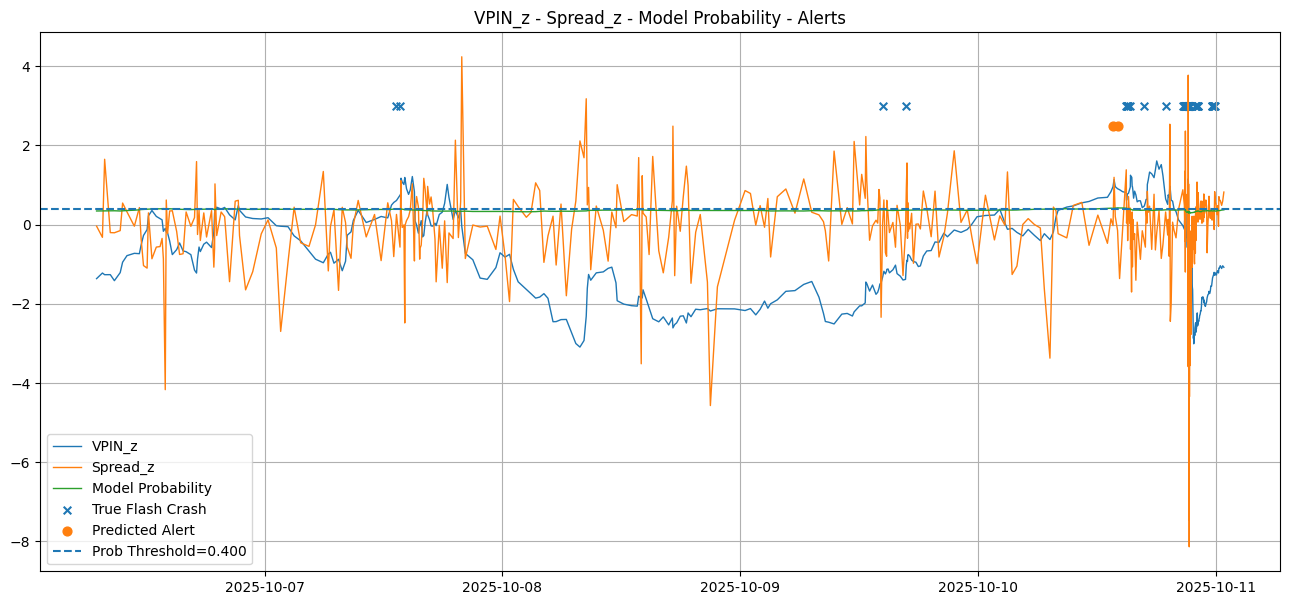

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16,7))

# --- VPIN_z ---
plt.plot(pred_df["Time"], pred_df["VPIN_z"], label="VPIN_z", linewidth=1)

# --- Spread_z ---
plt.plot(pred_df["Time"], pred_df["BidAskSpread_z"], label="Spread_z", linewidth=1)

# --- y_prob ---
plt.plot(pred_df["Time"], pred_df["y_prob"], label="Model Probability", linewidth=1)

# --- Flash crash thật ---
true_times = pred_df.loc[np.array(y_true)==1, "Time"]
plt.scatter(true_times, [3]*len(true_times), marker="x", s=30, label="True Flash Crash")

# --- Alert dự đoán ---
alert_times = alerts["Time"]
plt.scatter(alert_times, [2.5]*len(alert_times), marker="o", s=40, label="Predicted Alert")

plt.axhline(best_thr, linestyle="--", label=f"Prob Threshold={best_thr:.3f}")

plt.title("VPIN_z - Spread_z - Model Probability - Alerts")
plt.legend()
plt.grid()
plt.show()


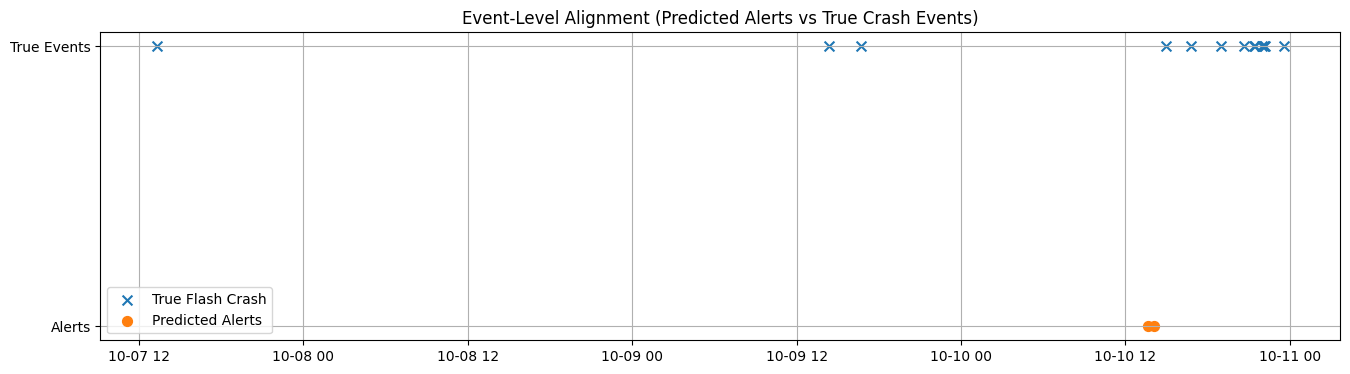

In [20]:
plt.figure(figsize=(16,4))

# true flash crash
plt.scatter(true_events, [1]*len(true_events), label="True Flash Crash", marker="x", s=50)

# predicted alert
plt.scatter(alerts["Time"], [0.5]*len(alerts), label="Predicted Alerts", marker="o", s=50)

plt.yticks([0.5, 1], ["Alerts", "True Events"])
plt.title("Event-Level Alignment (Predicted Alerts vs True Crash Events)")
plt.grid()
plt.legend()
plt.show()


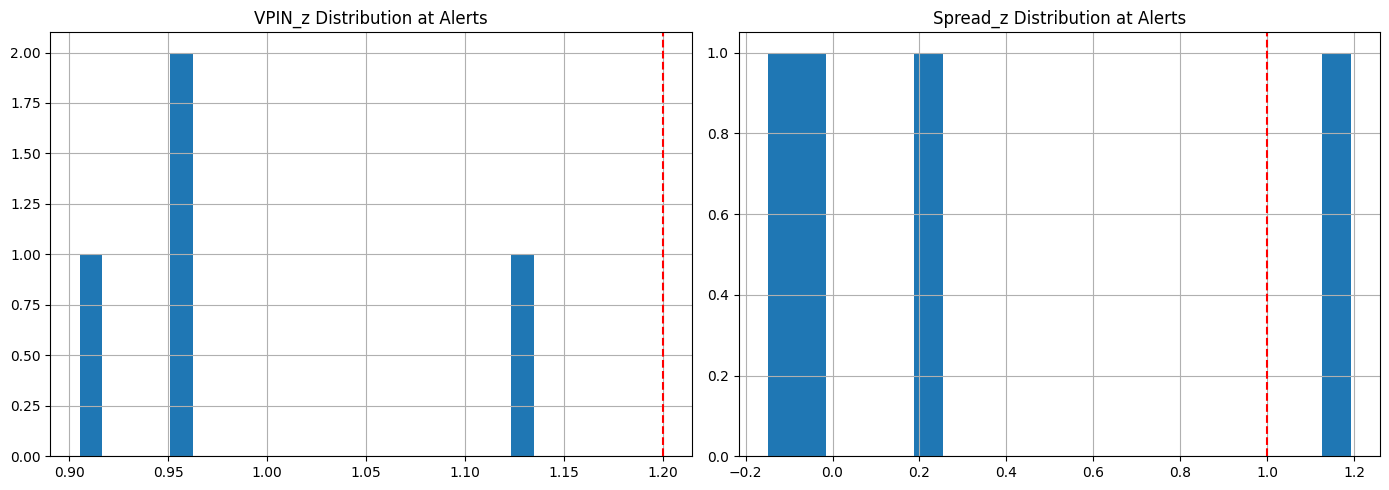

In [21]:
plt.figure(figsize=(14,5))

vals_vpin = pred_df.loc[mask_final, "VPIN_z"]
vals_spread = pred_df.loc[mask_final, "BidAskSpread_z"]

plt.subplot(1,2,1)
plt.hist(vals_vpin, bins=20)
plt.axvline(vthr, color="r", linestyle="--")
plt.title("VPIN_z Distribution at Alerts")
plt.grid()

plt.subplot(1,2,2)
plt.hist(vals_spread, bins=20)
plt.axvline(sthr, color="r", linestyle="--")
plt.title("Spread_z Distribution at Alerts")
plt.grid()

plt.tight_layout()
plt.show()


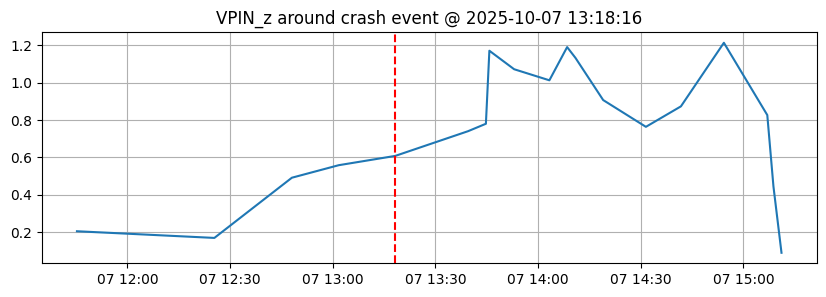

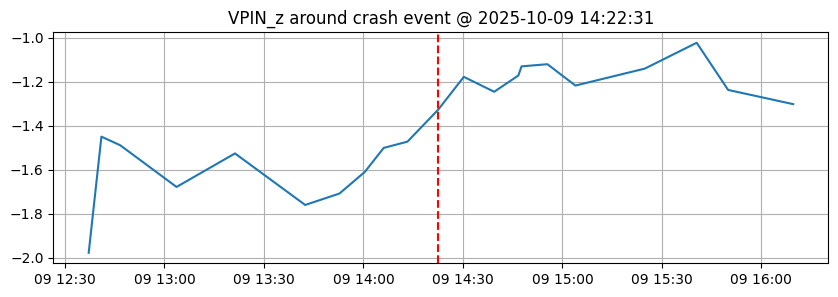

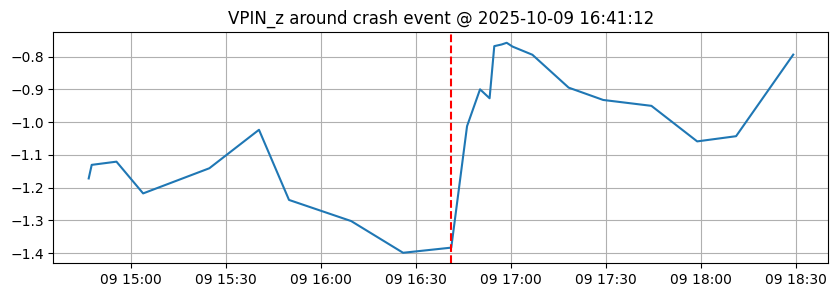

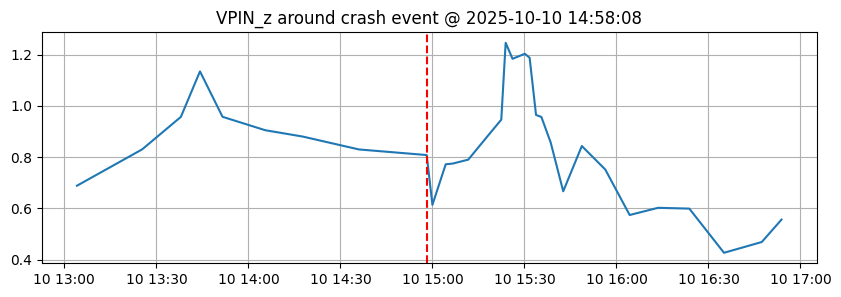

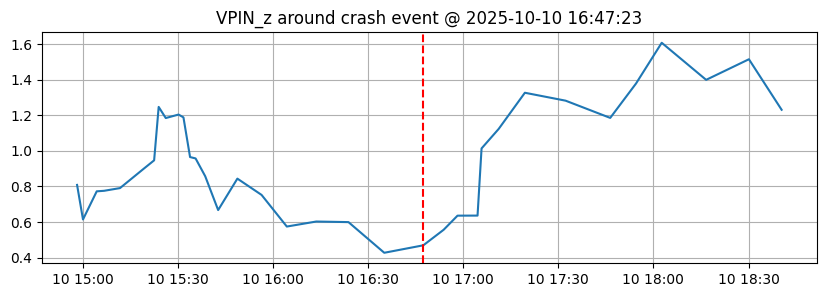

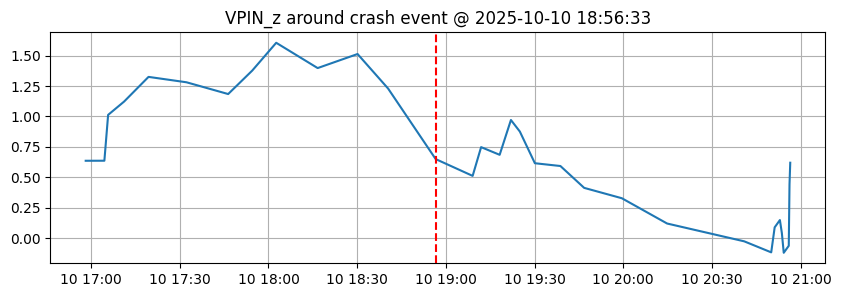

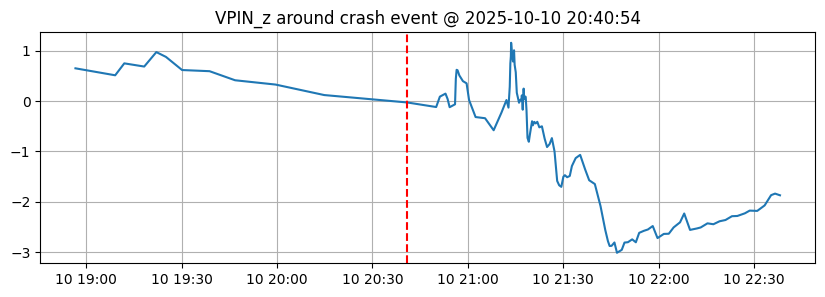

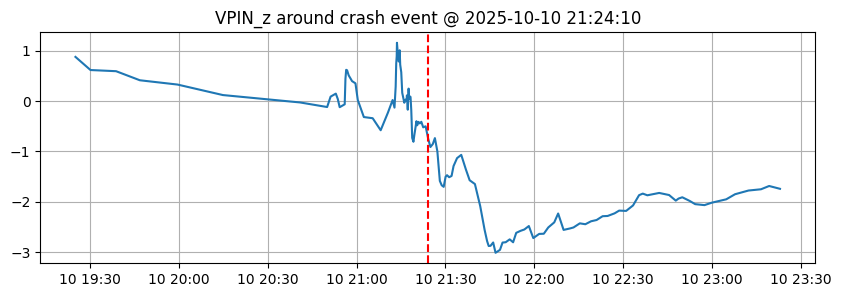

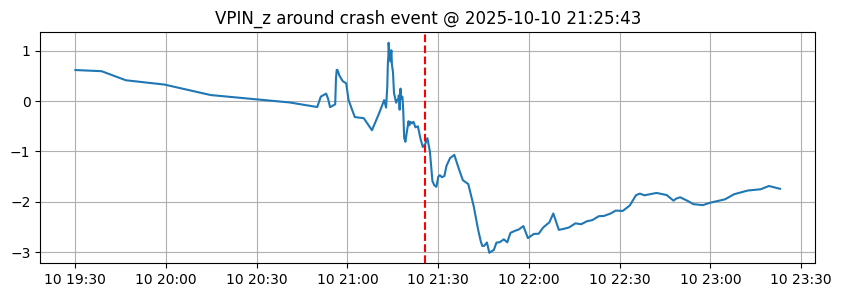

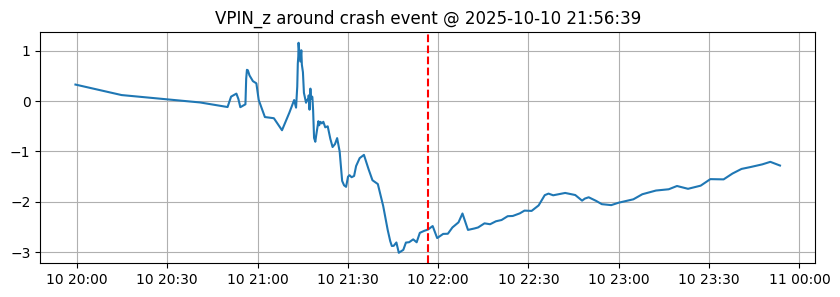

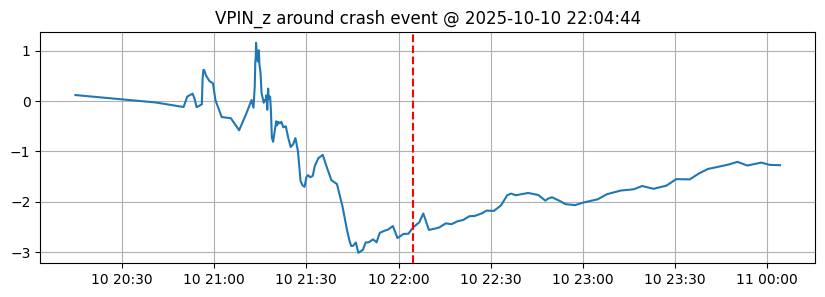

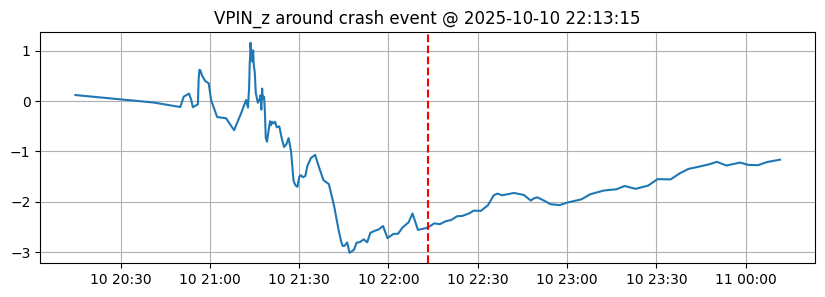

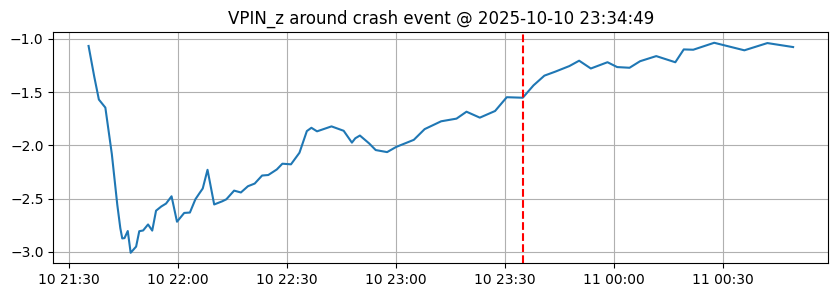

In [22]:
win = pd.Timedelta("2h")

for ev in true_events:
    df = pred_df[(pred_df['Time']>=ev-win) & (pred_df['Time']<=ev+win)]
    plt.figure(figsize=(10,3))
    plt.plot(df["Time"], df["VPIN_z"], label="VPIN_z")
    plt.axvline(ev, color="red", linestyle="--")
    plt.title(f"VPIN_z around crash event @ {ev}")
    plt.grid(True)
    plt.show()
